In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [2]:
!ls datasets

sample_submission.csv  test  train  train.csv  train_sets.csv  val_sets.csv


In [3]:
train_df = pd.read_csv('datasets/train.csv')

## Explore proportion of each whale ID

In [13]:
train_df['Id'].value_counts()

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
            ... 
w_7440549      1
w_afbc2d1      1
w_c07f119      1
w_7ad8bb3      1
w_f400702      1
Name: Id, Length: 4251, dtype: int64

In [21]:
train_df['Id'].value_counts().describe()

count    4251.000000
mean        2.317102
std        12.586066
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       810.000000
Name: Id, dtype: float64

From above, We'll see this dataset is very unbalance. More than 50% of total whale ID have only single image and whale ID that has the most sample of image is "new_whale".

In [112]:
print('number of images', len(train_df))
print('number of categories :', len(train_df['Id'].value_counts()))

whale_counts = train_df['Id'].value_counts()
num_single_img_whale = whale_counts[whale_counts == 1].sum()
print(f'number of single whale image : {num_single_img_whale} types')
print(f'{num_single_img_whale / len(train_df) * 100}% of datasets')
print(f'{num_single_img_whale / len(whale_counts) * 100}% of total whale type')

number of images 9850
number of categories : 4251
number of single whale image : 2220 types
22.538071065989847% of datasets
52.22300635144672% of total whale type


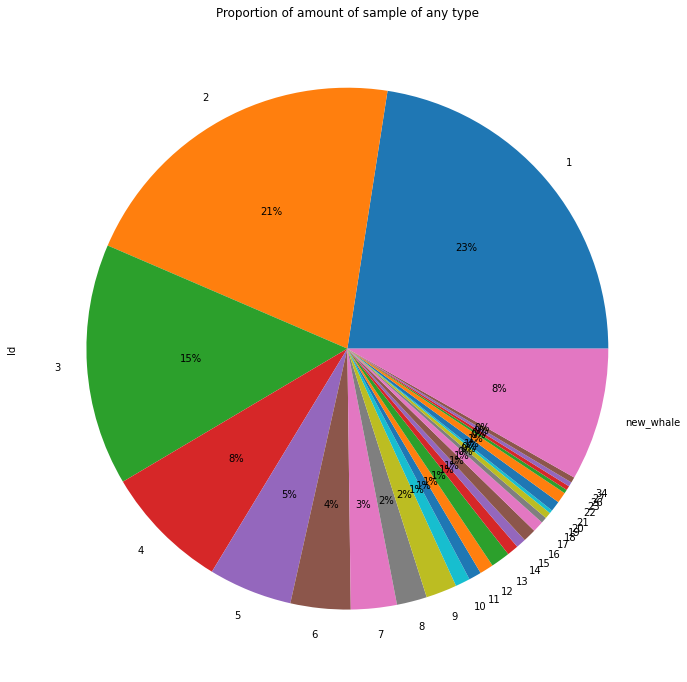

In [111]:
whale_counts = train_df['Id'].value_counts()

number_sample_each_type_proportion = whale_counts.groupby(whale_counts).sum()
number_sample_each_type_proportion.index.name = 'number of sample'
number_sample_each_type_proportion.rename(index={810: 'new_whale'}, inplace=True)
number_sample_each_type_proportion.plot(kind='pie',
                                        autopct='%1.0f%%',
                                        figsize=(12, 12),
                                        title='Proportion of amount of sample of any type'
                                       )


Text(0.5, 0, 'Amount of sample')

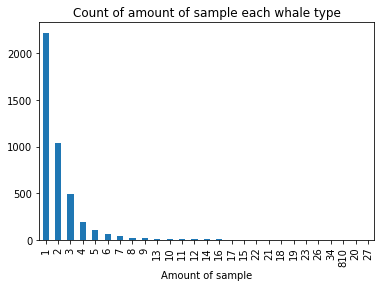

In [95]:
train_df['Id'].value_counts().value_counts().plot(kind='bar', title='Count of amount of sample each whale type')
plt.xlabel('Amount of sample')

## Explore image data

We will see characteristic of any whale images. From exploration, we found the main characteristic of any whale is the white skin on its fin and that white skin look like wave of the sea :(


In [67]:
dataset_dir = Path('datasets/train/train')


def plot_whale_images(whale_df, title=None, n_cols=4, figsize=(16, 10), message_func=None):
    fig, axes = plt.subplots(nrows=int(np.ceil(len(whale_df) / n_cols)), ncols=n_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title)
    for i, (_, whale) in enumerate(whale_df.iterrows()):
        img = cv2.imread(str(dataset_dir / whale['Image']))
        ax = axes[i // n_cols, i % n_cols]
        ax.axis('off')
        if message_func is not None:
            ax.set_title(message_func(whale['Image'], whale['Id'], img))
        ax.imshow(img[:, :, ::-1])
    plt.show()

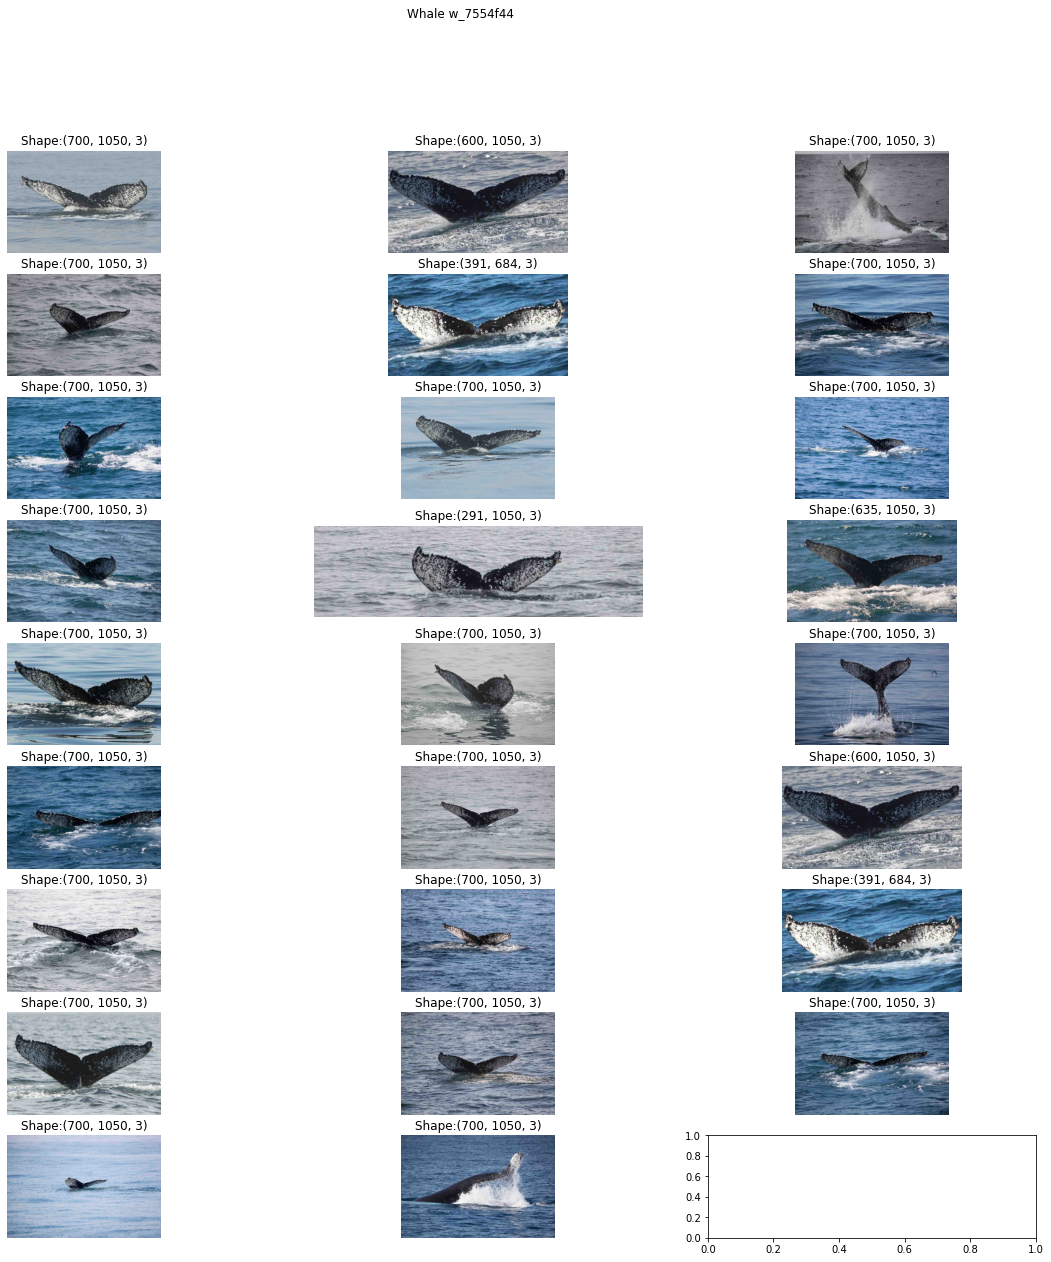

In [71]:
whale_id = 'w_7554f44'
whale_df = train_df[train_df['Id'] == whale_id]

message_func = lambda image_name, whale_id, img: f'Shape:{img.shape}' 
plot_whale_images(whale_df, title=f'Whale {whale_id}', n_cols=3, figsize=(20, 20), message_func=message_func)


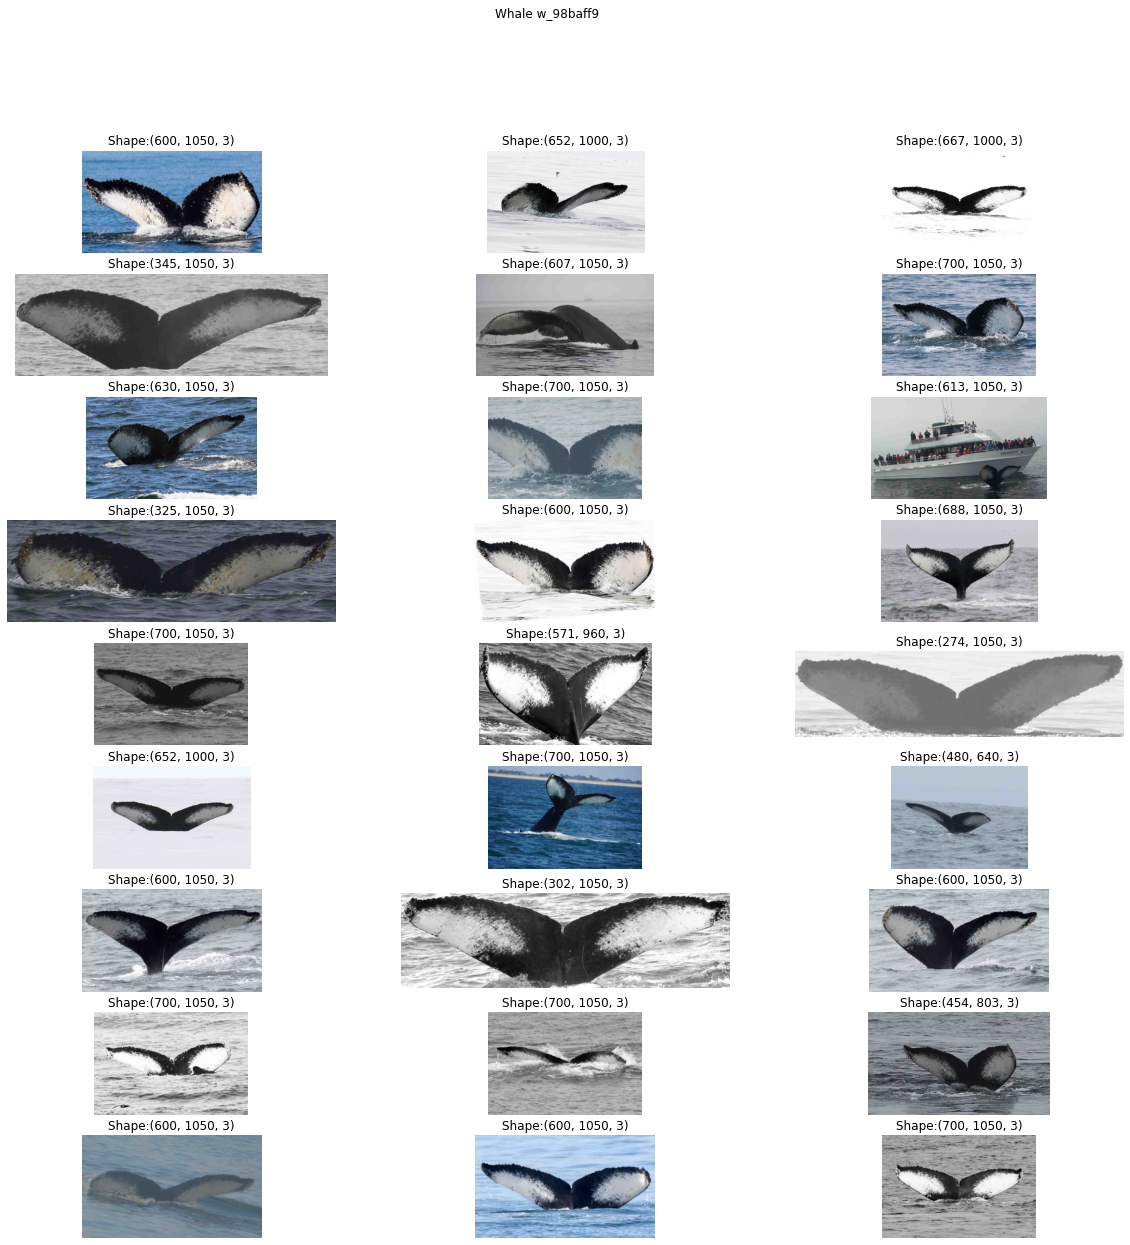

In [72]:

whale_id = 'w_98baff9'
whale_df = train_df[train_df['Id'] == whale_id]

message_func = lambda image_name, whale_id, img: f'Shape:{img.shape}' 
plot_whale_images(whale_df, title=f'Whale {whale_id}', n_cols=3, figsize=(20, 20), message_func=message_func)


Oh, I found the boat !

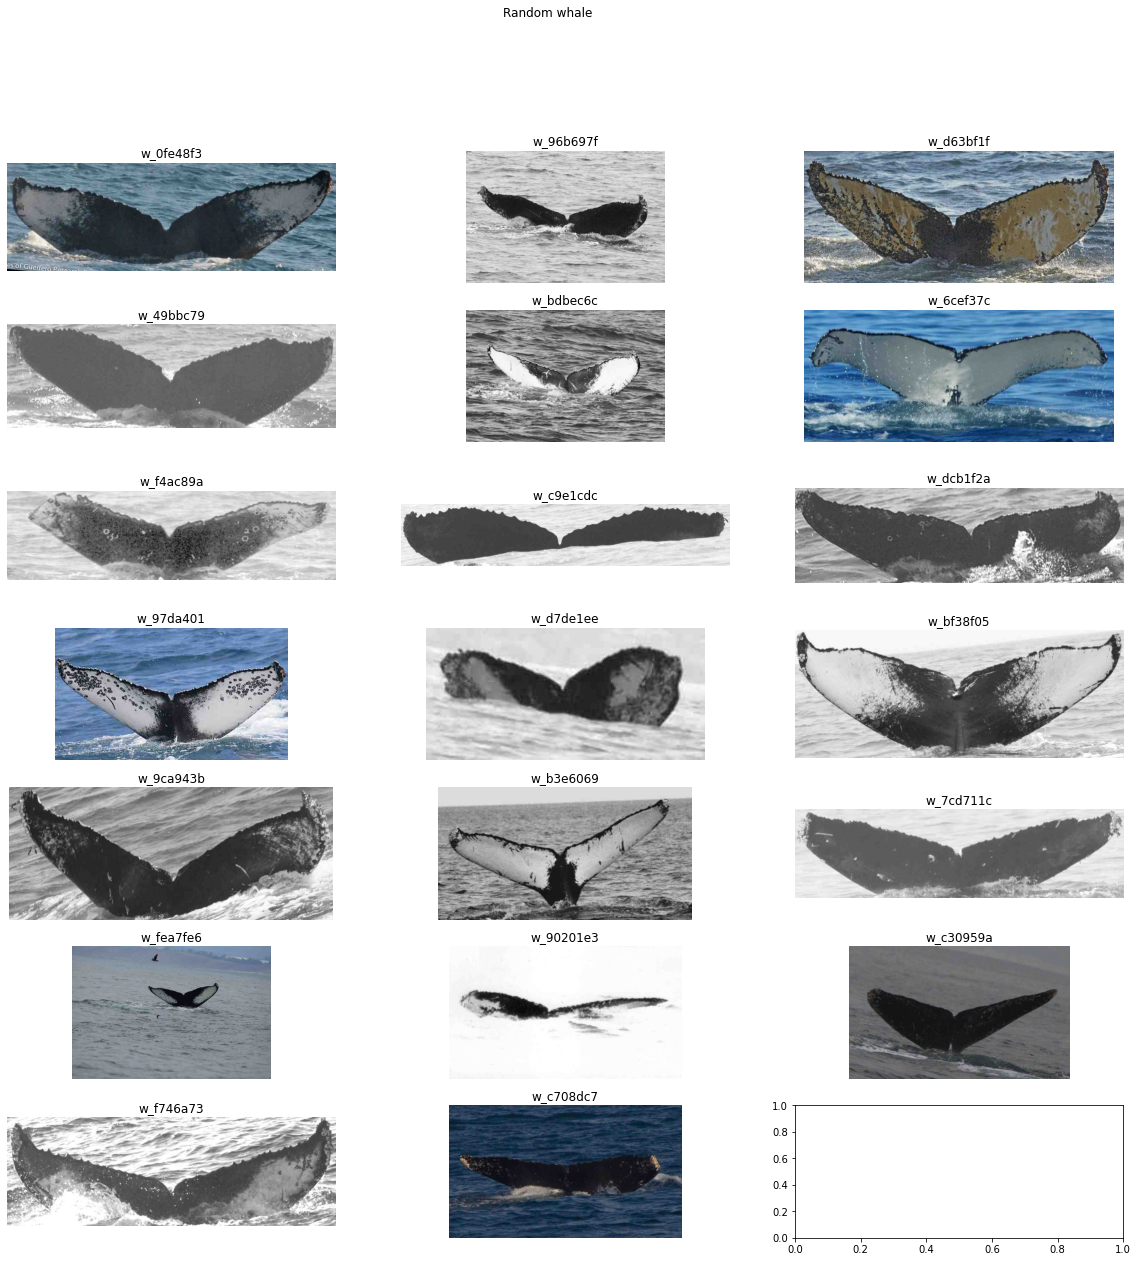

In [73]:
whale_df = train_df.sample(20)

message_func = lambda image_name, whale_id, img: f'{whale_id}' 
plot_whale_images(whale_df, title=f'Random whale', n_cols=3, figsize=(20, 20), message_func=message_func)


This dataset contains various of image shape and some of image are gray-scale image.

## Explore shape of image

In [24]:
from tqdm import tqdm_notebook

In [25]:
shapes = np.array([cv2.imread('datasets/train/train/'+img_name).shape[:2] 
                   for img_name in tqdm_notebook(train_df['Image'])])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


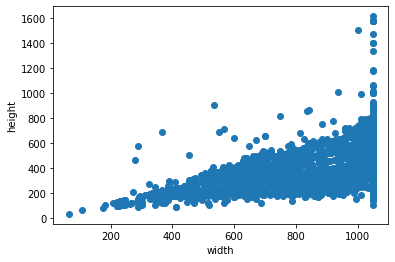

In [28]:
plt.xlabel('width')
plt.ylabel('height')
plt.scatter(x=shapes[:, 1], y=shapes[:, 0])

We found the most of whale image have landscape orientation. If we use build model with square input shape, we may loss importance feature from pre-processing (Resizing).

In [23]:
height, width = shapes.mean(axis=0).astype(int)
print(f'average resolution = width:{width}, height:{height}' )

average resolution = width:968, height:478


For this reason, we use average resolution of entire dataset to build model.